# AI-Poet
一款基于**深度学习**的 AI 写诗工具
#### id: 519021910861
#### name: 徐惠东
------

## 背景介绍

近年来，人工智能渗透了我们生活的方方面面，给我们的衣食住行都带来了不少便利。纵观当今的人工智能在交通管理、环境治理、数字能源和社会治理的应用，无论是推荐系统还是异常检测，他们都在为人们的生存和生活添砖加瓦。

然而，“生活不止眼前的苟且，还有**诗**和远方”。我们有理由相信，当人们的基本生活需求已经满足后，**作诗读诗**将会是人工智能的高层次应用。正如中国在盛唐时期古诗遍地开花，在不久的将来，人工智能写诗也必将掀起一波浪潮。

因此，AI-Poet 参考《Pytorch入门与实践》教程和 [GitLab 上开源代码框架](https://gitee.com/wannabe-9/LSTM_poem1)，采用[**循环神经网络 (RNN)**](https://zh.wikipedia.org/wiki/%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C)中的[**长短期记忆 (LSTM)**](https://zh.wikipedia.org/wiki/%E9%95%B7%E7%9F%AD%E6%9C%9F%E8%A8%98%E6%86%B6)模型进行训练，最终效果可以支持**首句续写**和**藏头诗**两种功能，并且实现了基本的音律和意境。

**关键词**

深度学习  循环神经网络  长短期记忆  预训练模型

## 代码实现

### Setup

In [69]:
# 上传本地训练集至云端
# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import tqdm
import numpy as np
import torch as t
import torch.nn as nn
from google.colab import files
from torch.utils.data import DataLoader
from torch import optim
!pip install torchnet
from torchnet import meter
import matplotlib.pyplot as plt
import time
import os

### Define Config

In [71]:
class Config(object):
    num_layers = 3  # LSTM层数
    data_path = '/content/drive/MyDrive/AI-Poet'  # 诗歌的文本文件存放路径
    pickle_path = 'tang.npz'  # 预处理好的二进制文件
    author = None  # 只学习某位作者的诗歌
    constrain = None  # 长度限制
    category = 'poet.tang'  # 类别，唐诗还是宋诗歌(poet.song)
    lr = 1e-3
    weight_decay = 1e-4
    use_gpu = True
    epoch = 50
    batch_size = 16
    maxlen = 125  # 超过这个长度的之后字被丢弃，小于这个长度的在前面补空格
    plot_every = 200  # 每20个batch 可视化一次
    # use_env = True # 是否使用visodm
    env = 'poetry'  # visdom env
    max_gen_len = 200
    max_gen_len_1 = 200
    max_gen_len_2 = 200
    debug_file = '/tmp/debugp'
    prefix_words = '仙路尽头谁为峰？一见无始道成空。'  # 不是诗歌的组成部分，用来控制生成诗歌的意境
    start_words = '闲云潭影日悠悠'  # 诗歌开始
    acrostic = False  # 是否是藏头诗
    embedding_dim = 256
    hidden_dim = 512
    basic_dir = '/content/drive/MyDrive/AI-Poet/Aftertrain-Pure'
    model_path = '/'.join([basic_dir, 'tang_model_49.pth']) # 预训练模型路径 
    # model_path = "" 
    # model_path = '/content/drive/MyDrive/AI-Poet/tang_new.pth'  
    model_prefix = '/'.join([basic_dir, 'tang_model']) # 模型保存路径
    metedata_path = '/'.join([basic_dir, 'metedata.txt']) # 元数据写入
    result_path = '/'.join([basic_dir, 'result.txt']) # 训练损失
    usage_path = '/'.join([basic_dir, 'usage.txt']) # 使用记录

# 将 Config 参数写入 result.txt
f = open(Config.metedata_path, 'w+')
f.write("num_layers: %d\n" % (Config.num_layers))
f.write("data_path: %s\n" % (Config.data_path))
f.write("pickle_path: %s\n" % (Config.pickle_path))
f.write("author: %s\n" % (Config.author))
f.write("constrain: %s\n" % (Config.constrain))
f.write("category: %s\n" % (Config.category))
f.write("lr: %s\n" % str(Config.lr))
f.write("weight_decay: %s\n" % str(Config.weight_decay))
f.write("use_gpu: %d\n" % (Config.use_gpu))
f.write("epoch: %d\n" % (Config.epoch))
f.write("batch_size: %d\n" % (Config.batch_size))
f.write("maxlen: %d\n" % (Config.maxlen))
f.write("plot_every: %d\n" % (Config.plot_every))
f.write("env: %s\n" % (Config.env))
f.write("max_gen_len: %d\n" % (Config.max_gen_len))
f.write("debug_file: %s\n" % (Config.debug_file))
f.write("model_path: %s\n" % (Config.model_path))
f.write("prefix_words: %s\n" % (Config.prefix_words))
f.write("start_words: %s\n" % (Config.start_words))
f.write("acrostic: %d\n" % (Config.acrostic))
f.write("embedding_dim: %d\n" % (Config.embedding_dim))
f.write("hidden_dim: %d\n" % (Config.hidden_dim))
f.write("basic_dir: %s\n" % (Config.basic_dir))
f.write("model_prefix: %s\n" % (Config.model_prefix))
f.write("metedata_path: %s\n" % (Config.metedata_path))
f.write("result_path: %s\n" % (Config.result_path))
f.write("usage_path: %s\n" % (Config.usage_path))
print("Write metedata successfully\n")
# 打印 GPU 信息

if Config.use_gpu: Config.device = t.device("cuda")
else: Config.device = t.device("cpu")

device = Config.device
print(device)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("Setup seccessfully\n")

Write metedata successfully

cuda
Tue Dec 28 14:55:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |   1079MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

### Load Data

In [72]:
datas = np.load("/content/drive/MyDrive/AI-Poet/tang.npz", allow_pickle=True)
data = datas['data']
ix2word = datas['ix2word'].item()
word2ix = datas['word2ix'].item()
data = t.from_numpy(data)
dataloader = DataLoader(data,
                        batch_size=Config.batch_size,
                        shuffle=True,
                        num_workers=2)
print("Load data successfully\n")

Load data successfully



### Define Model

In [73]:
class PoetryModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PoetryModel, self).__init__()
        self.hidden_dim = hidden_dim
        # 词向量层，词表大小 * 向量维度
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # 网络主要结构
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=Config.num_layers)
        # 进行分类
        self.linear = nn.Linear(self.hidden_dim, vocab_size)

    def forward(self, input, hidden=None):
        seq_len, batch_size = input.size()
        # print(input.shape)
        if hidden is None:
            h_0 = input.data.new(Config.num_layers, batch_size, self.hidden_dim).fill_(0).float()
            c_0 = input.data.new(Config.num_layers, batch_size, self.hidden_dim).fill_(0).float()
        else:
            h_0, c_0 = hidden
        # 输入 序列长度 * batch(每个汉字是一个数字下标)，
        # 输出 序列长度 * batch * 向量维度
        embeds = self.embeddings(input)
        # 输出hidden的大小： 序列长度 * batch * hidden_dim
        output, hidden = self.lstm(embeds, (h_0, c_0))
        output = self.linear(output.view(seq_len * batch_size, -1))
        return output, hidden

model = PoetryModel(len(word2ix),
                        embedding_dim=Config.embedding_dim,
                        hidden_dim=Config.hidden_dim)
Configimizer = optim.Adam(model.parameters(), lr=Config.lr)
criterion = nn.CrossEntropyLoss()
if Config.model_path:
    model.load_state_dict(t.load(Config.model_path, map_location='cpu'))

# 转移到相应计算设备上
model.to(device)
loss_meter = meter.AverageValueMeter()
print("Define model successfully\n")

Define model successfully



### Usage

In [74]:
# 给定首句生成诗歌
def generate(model, start_words, ix2word, word2ix, prefix_words=None):
    results = list(start_words)
    start_words_len = len(start_words)
    # 第一个词语是 <START>
    input = t.Tensor([word2ix['<START>']]).view(1, 1).long()
    if Config.use_gpu:
        input = input.cuda()
    hidden = None

    # 若有风格前缀，则先用风格前缀生成hidden
    if prefix_words:
        # 第一个input是<START>，后面就是prefix中的汉字
        # 第一个hidden是None，后面就是前面生成的hidden
        for word in prefix_words:
            output, hidden = model(input, hidden)
            input = input.data.new([word2ix[word]]).view(1, 1)

    # 开始真正生成诗句，如果没有使用风格前缀，则hidden = None，input = <START>
    # 否则，input就是风格前缀的最后一个词语，hidden也是生成出来的
    for i in range(Config.max_gen_len_1):
        output, hidden = model(input, hidden)
        # print(output.shape)
        # 如果还在诗句内部，输入就是诗句的字，不取出结果，只为了得到
        # 最后的hidden
        if i < start_words_len:
            w = results[i]
            input = input.data.new([word2ix[w]]).view(1, 1)
        # 否则将output作为下一个input进行
        else:
            # print(output.data[0].topk(1))
            top_index = output.data[0].topk(1)[1][0].item()
            w = ix2word[top_index]
            results.append(w)
            input = input.data.new([top_index]).view(1, 1)
        if w == '<EOP>':
            del results[-1]
            break
    return results

# 生成藏头诗
def gen_acrostic(model, start_words, ix2word, word2ix, prefix_words=None):
    result = []
    start_words_len = len(start_words)
    input = (t.Tensor([word2ix['<START>']]).view(1, 1).long())
    if Config.use_gpu:
        input = input.cuda()
    # 指示已经生成了几句藏头诗
    index = 0
    pre_word = '<START>'
    hidden = None

    # 存在风格前缀，则生成hidden
    if prefix_words:
        for word in prefix_words:
            output, hidden = model(input, hidden)
            input = (input.data.new([word2ix[word]])).view(1, 1)

    # 开始生成诗句
    for i in range(Config.max_gen_len_2):
        output, hidden = model(input, hidden)
        top_index = output.data[0].topk(1)[1][0].item()
        w = ix2word[top_index]
        # 说明上个字是句末
        if pre_word in {'。', '，', '?', '！', '<START>'}:
            if index == start_words_len:
                break
            else:
                w = start_words[index]
                index += 1
                # print(w,word2ix[w])
                input = (input.data.new([word2ix[w]])).view(1, 1)
        else:
            input = (input.data.new([top_index])).view(1, 1)
        result.append(w)
        pre_word = w
    return result
print("Define usage successfully\n")

Define usage successfully



### Train Data

In [75]:
loss_data = []

basic_start = 0
files = os.listdir(Config.basic_dir)
for filename in files:
  start_idx = filename.find("tang_model")
  if (start_idx != -1):
    start_idx += len("tang_model") + 1
    end_idx = filename.rfind(".")
    basic_start = max(basic_start, int(filename[start_idx:end_idx]))
basic_start += 1
print("Start from index: %d\n", basic_start)

# 进行训练并画图
def train():
  f = open(Config.result_path, 'w')
  for epoch in range(basic_start, Config.epoch):
      loss_meter.reset()
      for li, data_ in tqdm.tqdm(enumerate(dataloader)):
          # print(data_.shape)
          data_ = data_.long().transpose(1, 0).contiguous()
          # 注意这里，也转移到了计算设备上
          data_ = data_.to(device)
          Configimizer.zero_grad()
          # n个句子，前n-1句作为输入，后n-1句作为输出，二者一一对应
          input_, target = data_[:-1, :], data_[1:, :]
          output, _ = model(input_)
          # 这里为什么view(-1)
          print(target.shape, target.view(-1).shape)
          loss = criterion(output, target.view(-1))
          loss.backward()
          Configimizer.step()
          loss_meter.add(loss.item())
          # 存储 loss 数据，方便之后画图
          loss_data.append(loss)
          # 进行可视化
          if (1 + li) % Config.plot_every == 0:
              print("训练损失为%s\n" % (str(loss_meter.mean)))
              f.write("iteration: %d \t loss: %s\n" % (li + 1, str(loss_meter.mean)))
              for word in list(u"春江花朝秋月夜"):
                  gen_poetry = ''.join(generate(model, word, ix2word, word2ix))
                  f.write(gen_poetry)
                  f.write("\n")
                  f.flush()
      t.save(model.state_dict(), '%s_%s.pth' % (Config.model_prefix, epoch))

# train()
print("Train successfully\n")

Start from index: %d
 50
Train successfully



## 运行展示


[1.015, 1.134, 1.224, 1.299]


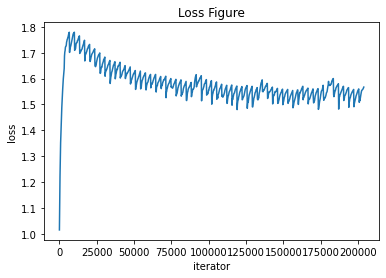

In [84]:
# 画图

def get_data(file_path):
  loss_data = []
  file = open(file_path, "r", encoding="utf-8", errors="ignore")
  
  start_idx = 0
  data = file.read()
  while True:
    start_idx = data.find("训练损失为", start_idx)
    if start_idx == -1: break
    start_idx += len("训练损失为")
    end_idx = data.find(".", start_idx) + 3
    loss = data[start_idx : end_idx + 1]
    loss_data.append(float(loss))
    start_idx = end_idx + 1
  

  # for line in file.readlines():
  #   start_idx = str(line).find("训练损失为")
  #   if (start_idx != -1):
  #     start_idx += len("训练损失为")
  #     end_idx = str(line).find(".", start_idx) + 3
  #     loss = str(line)[start_idx : end_idx + 1]
  #     loss_data.append(float(loss))

  print(loss_data[0:4])
  return loss_data

def plot_loss(loss_data):
  x = [200 * x for x in range(len(loss_data))]
  plt.plot(x, loss_data, '-')
  plt.xlabel("iterator")
  plt.ylabel("loss")
  plt.title("Loss Figure")
  plt.savefig("/content/drive/MyDrive/AI-Poet/result/resulte60.png")
  plt.show()

loss_data = get_data("/content/drive/MyDrive/AI-Poet/result/resulte60.txt")
plot_loss(loss_data)


### User Test

In [ ]:
f = open(Config.usage_path, 'a+')
f.write("%s\n" % str(time.asctime()))

def userTest():
    print("正在初始化......")
    datas = np.load('/'.join([Config.data_path, Config.pickle_path]), allow_pickle=True)
    data = datas['data']
    ix2word = datas['ix2word'].item()
    word2ix = datas['word2ix'].item()
    model = PoetryModel(len(ix2word), Config.embedding_dim, Config.hidden_dim)
    model.load_state_dict(t.load(Config.model_path, 'cpu'))
    if Config.use_gpu:
        model.to(t.device('cuda'))
    print("初始化完成！\n")
    while True:
        print("欢迎使用唐诗生成器，\n"
              "输入1 进入首句生成模式\n"
              "输入2 进入藏头诗生成模式\n")
        mode = int(input())
        if mode == 1:
            print("请输入您想要的诗歌首句，可以是五言或七言")
            start_words = str(input())
            print("请输入风格，\n"
                  "输入0 不使用风格\n"
                  "输入1 使用首句风格\n"
                  "或直接输入风格")
            style = str(input())
            if style == "0": style = None
            elif style == "1": style = start_words
            else: pass

            gen_poetry = ''.join(generate(model, start_words, ix2word, word2ix, style))
            print("生成的诗句如下：%s\n" % (gen_poetry))
            f.write("首句生成模式: %s\n %s\n" % (start_words, gen_poetry))
        elif mode == 2:
            print("请输入您想要的诗歌藏头部分，不超过16个字，最好是偶数")
            start_words = str(input())
            print("请输入风格，\n"
                  "输入0 不使用风格\n"
                  "输入1 使用藏头部分风格\n"
                  "或直接输入风格")
            style = str(input())
            if style == "0": style = None
            elif style == "1": style = start_words
            else: pass

            gen_poetry = ''.join(gen_acrostic(model, start_words, ix2word, word2ix, style))
            print("生成的诗句如下：%s\n" % (gen_poetry))
            f.write("藏头诗模式: %s\n %s\n" % (start_words, gen_poetry))
userTest()